In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
df = pd.read_csv('C:/Training/Academy/Statistics (Python)/Datasets/AirPassengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
timeseries.shape

(144, 1)

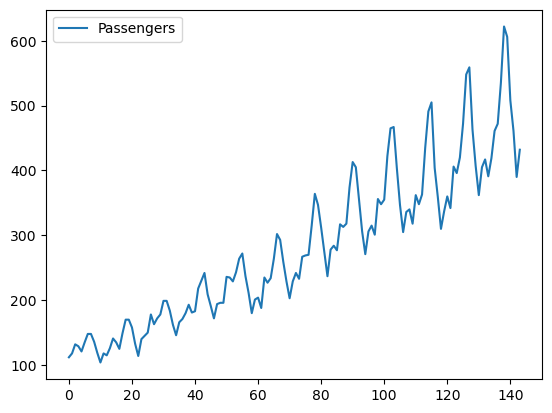

In [3]:
df.plot()
plt.show()

### train-test split for time series

In [4]:
len(timeseries)

144

In [5]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [6]:
train.shape, test.shape

((96, 1), (48, 1))

In [7]:
type(train)

numpy.ndarray

In [8]:
dataset=train
lookback=4
X, y = [], []
for i in range(len(dataset)-lookback):
    feature = dataset[i:i+lookback]
    target = dataset[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)

In [9]:
np.array(X)[:,:,0][0]

array([112., 118., 132., 129.], dtype=float32)

In [10]:
np.array(y)[:,:,0][0]

array([118., 132., 129., 121.], dtype=float32)

### Creating a Dataset

In [11]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [12]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\Sanjay Sane\AppData\Local\Temp\ipykernel_12816\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([92, 4, 1]),
 torch.Size([92, 4, 1]),
 torch.Size([44, 4, 1]),
 torch.Size([44, 4, 1]))

### Model Definition

In [14]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Initialization and settings

In [15]:
torch.manual_seed(23)
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         shuffle=True, batch_size=8)

### Training Loop

In [16]:
n_epochs = 2000
for epoch in range(0, n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))



Epoch 0: train RMSE 226.0930, test RMSE 425.3446
Epoch 100: train RMSE 180.8679, test RMSE 377.9529
Epoch 200: train RMSE 146.0038, test RMSE 340.0424
Epoch 300: train RMSE 116.8865, test RMSE 306.1135
Epoch 400: train RMSE 94.0317, test RMSE 275.8767
Epoch 500: train RMSE 69.8640, test RMSE 239.5905
Epoch 600: train RMSE 54.3600, test RMSE 210.8466
Epoch 700: train RMSE 43.5379, test RMSE 186.3809
Epoch 800: train RMSE 36.0424, test RMSE 164.9624
Epoch 900: train RMSE 30.9710, test RMSE 146.7285
Epoch 1000: train RMSE 27.3435, test RMSE 131.2956
Epoch 1100: train RMSE 25.3829, test RMSE 119.1102
Epoch 1200: train RMSE 23.7060, test RMSE 108.2624
Epoch 1300: train RMSE 22.5150, test RMSE 100.8727
Epoch 1400: train RMSE 22.2393, test RMSE 93.9882
Epoch 1500: train RMSE 20.8472, test RMSE 89.4040
Epoch 1600: train RMSE 20.4074, test RMSE 85.4845
Epoch 1700: train RMSE 20.6511, test RMSE 82.6651
Epoch 1800: train RMSE 19.9912, test RMSE 80.6120
Epoch 1900: train RMSE 19.5953, test RMSE 78

In [20]:
print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))

Epoch 2000: train RMSE 19.5953, test RMSE 78.3769


In [18]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

### Time Series

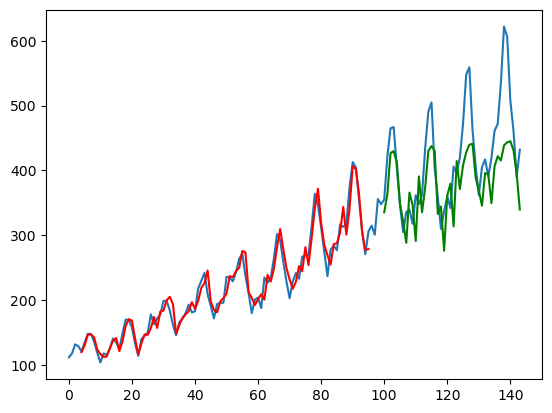

In [19]:
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()